### What this notebook will do:
This notebook will establish a rms/peak amplitude threshold below which an audio segment is considered silent and thus not to be added into any analysed data. The audio annotation analysis workflow is based on splitting a long audio file a few seconds long into smaller segments of sub-second length. These smaller segments are then analysed for various acoustic parameters. While these parameters may make sense for segments *with* calls in them, they do not make sense for segments without calls in them. eg. parameters like peak and dominant frequencies may actually show random values in the ultrasonic range and thus bias the dataset if such segments are not removed. 

### How is the 'threshold' for silent segments derived?
While searching for non-overlapping single calls, Aditya had to measure the signal-to-noise ratio (SNR) of the selected calls segment. He did so by measuring the rms of the selected call region along with the rms of a silent region within the same audio file if possible, otherwise used a silent region from another file. This means there are many single call annotations with silent intervals manually annotated. I will rely on these annotations to generate a threshold to define silent windows. 

I will *not* be looking into regions *with* calls as by definition the other regions with calls should have higher rms/peak amplitude. **The silent regions can vary in their duration, but I'll have to see how much they vary as such**


### Can I actually set a global threshold
Yes -- **but still needs verification**, because on the nights that the current data has been collected the gain settings were the same.

- Author: Thejasvi Beleyur

- Date of initiation: 2020-07-10


In [1]:
import datetime as dt
import glob
import os
import sys 
sys.path.append('../individual_call_analysis/analysis/')
from format_and_clean import ind_call_format as icf
from measure_annot_audio import inbuilt_measurement_functions as imf
import matplotlib.pyplot as plt
plt.rcParams['agg.path.chunksize'] = 10000
import numpy as np 
import pandas as pd
import scipy.signal as signal
import soundfile as sf


In [2]:
print(f'This notebook run was startd at: {dt.datetime.now()}')

This notebook run was startd at: 2020-07-11 16:13:32.913366


In [3]:
%matplotlib notebook

#### Load the valid annotations 
This file ('valid_annotations.csv') has all the valid annotations with the target species in it. 

In [4]:
valid_annots = pd.read_csv('valid_annotations.csv')
valid_annots

,Unnamed: 0,valid_annotations
0,0,matching_annotaudio_Aditya_2018-08-16_21502300_9
1,1,matching_annotaudio_Aditya_2018-08-16_21502300_12
2,2,matching_annotaudio_Aditya_2018-08-16_21502300_18
3,3,matching_annotaudio_Aditya_2018-08-16_21502300_19
4,4,matching_annotaudio_Aditya_2018-08-16_21502300_20
...,...,...
624,624,matching_annotaudio_Aditya_2018-08-20_0300-040...
625,625,matching_annotaudio_Aditya_2018-08-20_0300-040...
626,626,matching_annotaudio_Aditya_2018-08-20_0300-040...
627,627,matching_annotaudio_Aditya_2018-08-20_0300-040...


#### See which individual call annotations have entries for silent regions of audio.
Sometimes the silent region from another file was used to calculate the signal-to-noise ratio of a selected single call. 

- For those annotations which have valid silent region timestamps load the corresponding region of audio and calculate its rms and peak amplitude. This will allow us to generate a threshold to separate silent segments with segments with sound in them. 

- All analyses will be done on the high-pass filtered audio only!! 


In [5]:
def get_silent_start_stop(valid_annots, annot_folder):
    '''
    '''
    all_annotations = icf.read_all_annotation_files(annot_folder)
    relevant_annots = all_annotations[all_annotations['audio_annotation_file'].isin(valid_annots['valid_annotations'])]
    return relevant_annots.reset_index(drop=True)

In [6]:
silent_startstop = get_silent_start_stop(valid_annots,
                                         '../individual_call_analysis/raw_individual_call_annotations/')
silent_startstop


,audio_annotation_file,start_random_point,search_start_time(s),Direction,No._of_ms_whole_screen,call_start_time,call_end_time,SNR(dB RMS),Silent_period_Start,Silent_period_end,...,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,fm2_start_time,fm2_end_time,fm2_dbrms
0,matching_annotaudio_Aditya_2018-08-20_0300-040...,0.71,1.2496,R,55.0,0.466,0.498,30.92,0.513,0.519,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,matching_annotaudio_Aditya_2018-08-20_0300-040...,0.30,0.6,R,60.0,0.619,0.638,30.50,0.596,0.604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,matching_annotaudio_Aditya_2018-08-20_0300-040...,0.88,0.5984,R,80.0,0.035,0.067,23.88,0.088,0.104,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,matching_annotaudio_Aditya_2018-08-20_0300-040...,0.79,0.5688,L,45.0,0.040,0.062,21.34,0.030,0.037,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,matching_annotaudio_Aditya_2018-08-20_0300-040...,0.24,0.2016,R,55.0,0.267,0.286,26.69,0.256,0.263,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,matching_annotaudio_Aditya_2018-08-16_21502300...,0.66,0.4752,L,45.0,0.118,0.137,28.22,0.107,0.114,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
682,matching_annotaudio_Aditya_2018-08-16_21502300...,0.32,0.2432,L,50.0,0.628,0.646,26.91,0.457,0.462,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
683,matching_annotaudio_Aditya_2018-08-16_21502300...,0.67,0.2948,L,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
684,matching_annotaudio_Aditya_2018-08-16_21502300...,0.17,0.1292,L,50.0,0.093,0.114,30.33,0.242,0.248,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
### remove the nans in the silent period annotations 
all_na_rows = np.logical_or(pd.isna(silent_startstop['Silent_period_Start']),
                            pd.isna(silent_startstop['Silent_period_end']))
rows_to_be_kept = np.invert(all_na_rows)

silent_startstop = silent_startstop[rows_to_be_kept]
silent_startstop

,audio_annotation_file,start_random_point,search_start_time(s),Direction,No._of_ms_whole_screen,call_start_time,call_end_time,SNR(dB RMS),Silent_period_Start,Silent_period_end,...,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,fm2_start_time,fm2_end_time,fm2_dbrms
0,matching_annotaudio_Aditya_2018-08-20_0300-040...,0.71,1.2496,R,55.0,0.466,0.498,30.92,0.513,0.519,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,matching_annotaudio_Aditya_2018-08-20_0300-040...,0.30,0.6,R,60.0,0.619,0.638,30.50,0.596,0.604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,matching_annotaudio_Aditya_2018-08-20_0300-040...,0.88,0.5984,R,80.0,0.035,0.067,23.88,0.088,0.104,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,matching_annotaudio_Aditya_2018-08-20_0300-040...,0.79,0.5688,L,45.0,0.040,0.062,21.34,0.030,0.037,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,matching_annotaudio_Aditya_2018-08-20_0300-040...,0.24,0.2016,R,55.0,0.267,0.286,26.69,0.256,0.263,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,matching_annotaudio_Aditya_2018-08-16_21502300...,0.36,0.3168,R,55.0,0.364,0.385,46.08,0.348,0.362,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
681,matching_annotaudio_Aditya_2018-08-16_21502300...,0.66,0.4752,L,45.0,0.118,0.137,28.22,0.107,0.114,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
682,matching_annotaudio_Aditya_2018-08-16_21502300...,0.32,0.2432,L,50.0,0.628,0.646,26.91,0.457,0.462,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
684,matching_annotaudio_Aditya_2018-08-16_21502300...,0.17,0.1292,L,50.0,0.093,0.114,30.33,0.242,0.248,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
silent_startstop.to_csv('silent_startstop.csv')

In [9]:
from platform import python_version

print(python_version())

3.7.0


### Run the raw silent audio extraction

In [10]:
%run -i extracting_silent_audio_clips.py

Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!

### Create high-passed version of the silent audio and save these files into 'hp_silence_audio' folder

In [11]:
%run -i high_pass_filter_silent_audio.py
# See the source .py file for the reasons behind why some .WAV files could not be processed

Could not process: silence_audio/silence_matching_annotaudio_Aditya_2018-08-17_23_173.WAV
Could not process: silence_audio/silence_matching_annotaudio_Aditya_2018-08-16_21502300_9.WAV
Could not process: silence_audio/silence_matching_annotaudio_Aditya_2018-08-19_0120-0200_90.WAV
Could not process: silence_audio/silence_matching_annotaudio_Aditya_2018-08-17_23_70.WAV
Could not process: silence_audio/silence_matching_annotaudio_Aditya_2018-08-19_0120-0200_117.WAV


### Load all audio files and perform measurements on them 

In [12]:
hp_folder = 'hp_silence_audio/'
all_hp_files = glob.glob(hp_folder+'*.WAV')

all_rms = []
all_peak_amp = []
all_durns = []
for each in all_hp_files:
    audio, fs = sf.read(each)
    all_rms.append(imf.rms(audio)['rms'])
    all_peak_amp.append(imf.peak_amplitude(audio)['peak_amplitude'])
    all_durns.append(audio.size/fs)
    
audio_measurements = pd.DataFrame(data={'silence_file_name':all_hp_files})   
audio_measurements['rms'] = all_rms
audio_measurements['peak_amplitude'] = all_peak_amp
audio_measurements['duration'] = all_durns
audio_measurements['db_rms'] = imf.dB(audio_measurements['rms'])
audio_measurements['db_peak'] = imf.dB(audio_measurements['peak_amplitude'])

In [13]:
audio_measurements

,silence_file_name,rms,peak_amplitude,duration,db_rms,db_peak
0,hp_silence_audio/silence_matching_annotaudio_A...,0.001087,0.003754,0.008,-59.271722,-48.510896
1,hp_silence_audio/silence_matching_annotaudio_A...,0.001129,0.003876,0.011,-58.945070,-48.232924
2,hp_silence_audio/silence_matching_annotaudio_A...,0.001236,0.004761,0.013,-58.159453,-46.446507
3,hp_silence_audio/silence_matching_annotaudio_A...,0.001236,0.004120,0.011,-58.162041,-47.702323
4,hp_silence_audio/silence_matching_annotaudio_A...,0.001092,0.003784,0.015,-59.238273,-48.440565
...,...,...,...,...,...,...
411,hp_silence_audio/silence_matching_annotaudio_A...,0.001235,0.004578,0.015,-58.168680,-46.787174
412,hp_silence_audio/silence_matching_annotaudio_A...,0.001188,0.003937,0.004,-58.502944,-48.097204
413,hp_silence_audio/silence_matching_annotaudio_A...,0.001355,0.005890,0.012,-57.364124,-44.597853
414,hp_silence_audio/silence_matching_annotaudio_A...,0.001340,0.005280,0.018,-57.460949,-45.548077


## Raw data inspections

### How long are the silent regions ?

<IPython.core.display.Javascript object>


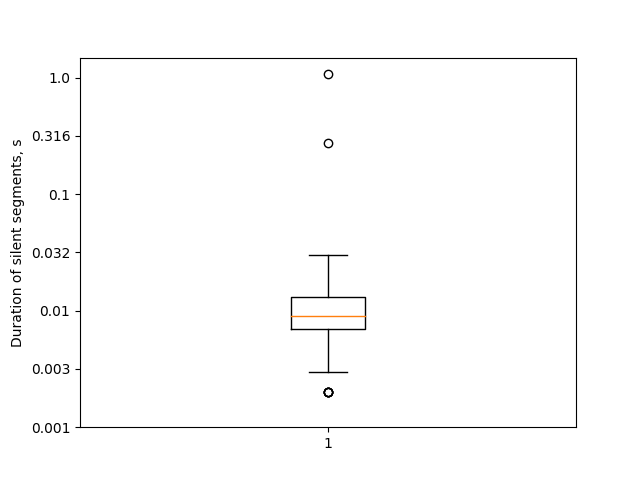

In [14]:
plt.figure()
plt.boxplot(imf.dB(audio_measurements['duration']));
plt.ylabel('Duration of silent segments, s')

db_values = np.array([0,-10,-20,-30,-40,-50,-60]);
plt.yticks(db_values, np.round(10**(db_values/20),3));

In [15]:
np.percentile(audio_measurements['duration'], [25,75])

array([0.007, 0.013])

In [16]:
np.percentile(audio_measurements['duration'],[0,100])

array([0.002, 1.084])

#### The silent annotations are mostly between 7-13 ms, with a maximum of ~1 second long, and a minimum going upto 2 ms.

### The silent durations are somewhat shorter than the size of the window - but not too short. ie. 7-13 ms corresponds to about 14-28 % of the 50ms audio segments used in the final analysis. This is not too bad I think - and so whatever rms/peak values we get from this analysis will be useful. To be safe, I will also add a 20dB additional threshold to reduce the chance of false positives. 

### What is the distribution of RMS of silent audio regions?

<IPython.core.display.Javascript object>


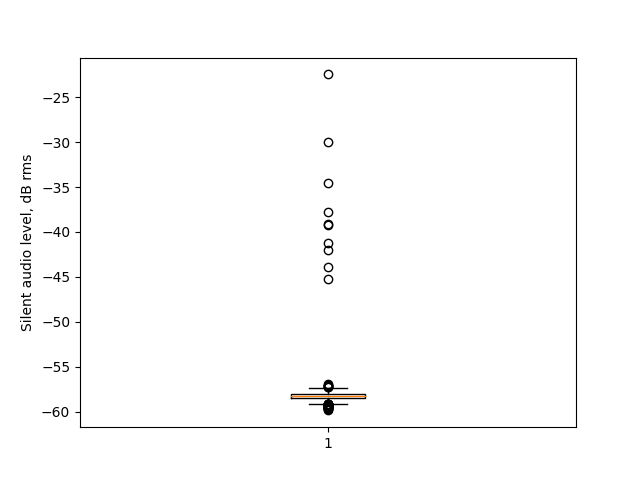

Text(0, 0.5, 'Silent audio level, dB rms')

In [17]:
plt.figure()
plt.boxplot(audio_measurements['db_rms'])
plt.ylabel('Silent audio level, dB rms')

<IPython.core.display.Javascript object>


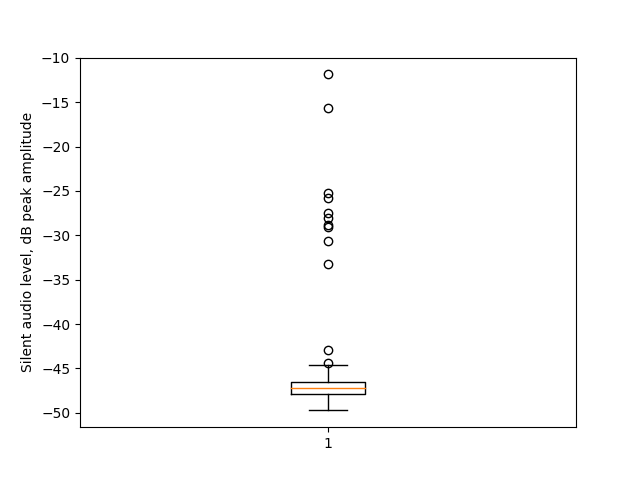

Text(0, 0.5, 'Silent audio level, dB peak amplitude')

In [18]:
plt.figure()
plt.boxplot(audio_measurements['db_peak'])
plt.ylabel('Silent audio level, dB peak amplitude')

###  There seem to be some surprisingly 'loud' *silent* regions - let me check these manually to understand what contributes to their sound levels. I'll be using the rms because it is more robust than the peak amplitude. 

In [19]:
loud_silent_audios = audio_measurements[audio_measurements['db_rms']>-50].reset_index(drop=True)
loud_silent_audios['silence_file_name'][2]

'hp_silence_audio/silence_matching_annotaudio_Aditya_2018-08-17_56_58_hp.WAV'

hp_silence_audio/silence_matching_annotaudio_Aditya_2018-08-17_56_58_hp.WAV


<IPython.core.display.Javascript object>


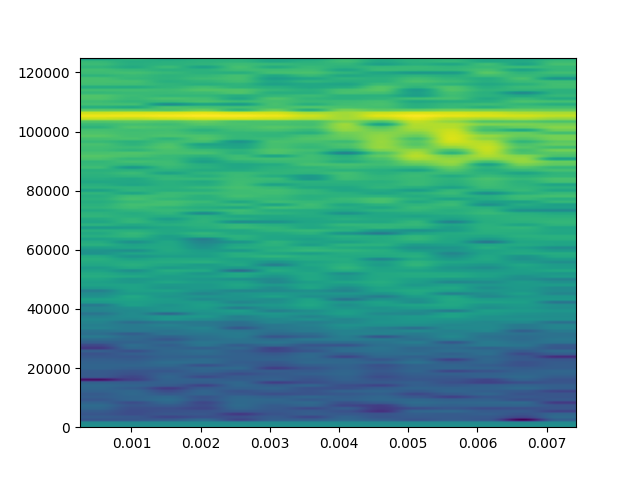

In [20]:
filepath = loud_silent_audios['silence_file_name'][2]
print(filepath)
audio,fs = sf.read(filepath)

plt.figure()
plt.specgram(audio, Fs=fs);

- silence_matching_annotaudio_Aditya_2018-08-17_12_76_hp.WAV : Actually has a call in it. 
- silence_matching_annotaudio_Aditya_2018-08-17_34_81_hp.WAV : CF reverberation 
- silence_matching_annotaudio_Aditya_2018-08-17_56_58_hp.WAV : end of a CF call included in annotation
- silence_matching_annotaudio_Aditya_2018-08-17_34_111_hp.WAV : end of a CF call included in annotation
- silence_matching_annotaudio_Aditya_2018-08-17_34_2_hp.WAV : multiple calls in this section
- silence_matching_annotaudio_Aditya_2018-08-19_23_5_hp.WAV : CF + faint FMs 
- silence_matching_annotaudio_Aditya_2018-08-17_45_122_hp.WAV : end of a CF call included in annotaiton 
- silence_matching_annotaudio_Aditya_2018-08-17_01_28_hp.WAV : end of a CF call included in annotaiton 
- silence_matching_annotaudio_Aditya_2018-08-17_23_56_hp.WAV : multiple calls in this section
- silence_matching_annotaudio_Aditya_2018-08-19_23_40_hp.WAV : end of a CF call included in annotaiton 

Let's remove these erroneous annotations and proceed to see how the received level of silent regions is


In [21]:
to_remove = loud_silent_audios['silence_file_name']
valid_measurements = audio_measurements[~audio_measurements['silence_file_name'].isin(to_remove)].reset_index(drop=True)
valid_measurements

,silence_file_name,rms,peak_amplitude,duration,db_rms,db_peak
0,hp_silence_audio/silence_matching_annotaudio_A...,0.001087,0.003754,0.008,-59.271722,-48.510896
1,hp_silence_audio/silence_matching_annotaudio_A...,0.001129,0.003876,0.011,-58.945070,-48.232924
2,hp_silence_audio/silence_matching_annotaudio_A...,0.001236,0.004761,0.013,-58.159453,-46.446507
3,hp_silence_audio/silence_matching_annotaudio_A...,0.001236,0.004120,0.011,-58.162041,-47.702323
4,hp_silence_audio/silence_matching_annotaudio_A...,0.001092,0.003784,0.015,-59.238273,-48.440565
...,...,...,...,...,...,...
401,hp_silence_audio/silence_matching_annotaudio_A...,0.001235,0.004578,0.015,-58.168680,-46.787174
402,hp_silence_audio/silence_matching_annotaudio_A...,0.001188,0.003937,0.004,-58.502944,-48.097204
403,hp_silence_audio/silence_matching_annotaudio_A...,0.001355,0.005890,0.012,-57.364124,-44.597853
404,hp_silence_audio/silence_matching_annotaudio_A...,0.001340,0.005280,0.018,-57.460949,-45.548077


## Cleaned silent audio measurements : dB rms and dB peak amplitude

<IPython.core.display.Javascript object>


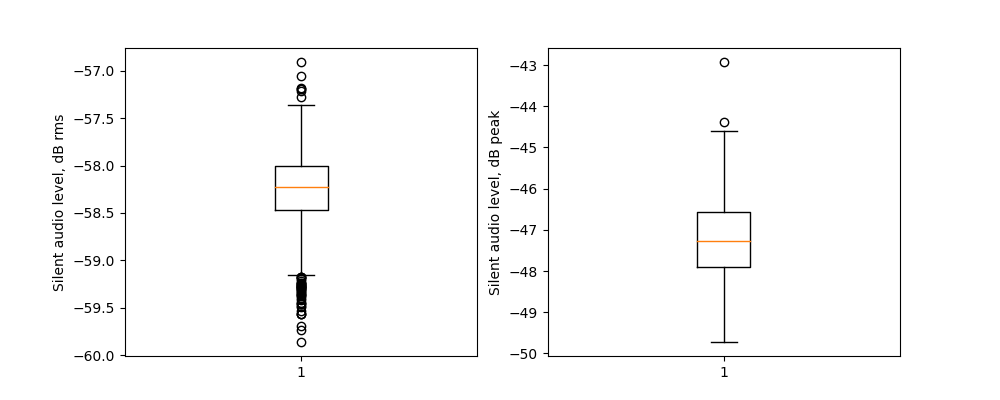

Text(0, 0.5, 'Silent audio level, dB peak')

In [22]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.boxplot(valid_measurements['db_rms'])
plt.ylabel('Silent audio level, dB rms')
plt.subplot(122)
plt.boxplot(valid_measurements['db_peak'])
plt.ylabel('Silent audio level, dB peak')


<IPython.core.display.Javascript object>


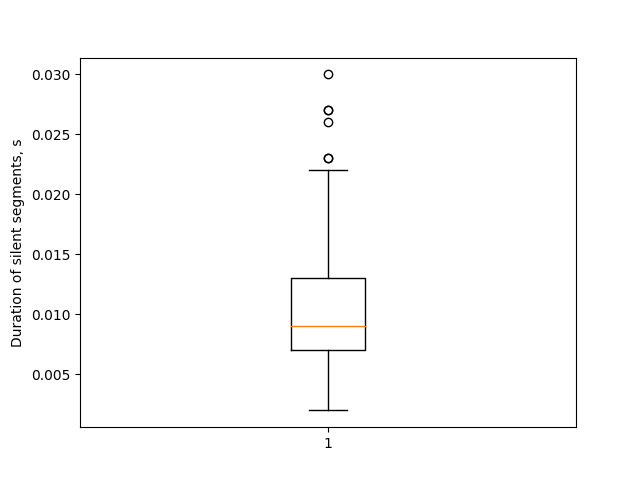

Text(0, 0.5, 'Duration of silent segments, s')

In [23]:
plt.figure()
plt.boxplot(valid_measurements['duration']);
plt.ylabel('Duration of silent segments, s')

In [24]:
threshold_snr = 20

call_threshold_dBrms = np.round(np.max(valid_measurements['db_rms']) + threshold_snr)
call_threshold_dBpeak = np.round(np.max(valid_measurements['db_peak']) + threshold_snr)
print(call_threshold_dBrms, call_threshold_dBpeak)

call_threshold = pd.DataFrame(data={'call_dbpeak_threshold':[call_threshold_dBpeak],
                                   'call_dbrms_threshold':[call_threshold_dBrms]})
call_threshold.to_csv('call_threshold_levels.csv')

-37.0 -23.0


In [25]:
print(f'This notebook run ended at: {dt.datetime.now()}')

This notebook run ended at: 2020-07-11 16:13:40.119919
